In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
import pylab as py
import random
import pandas as pd
from matplotlib import gridspec
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from datetime import datetime
import time
import corner
import emcee
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
from ltsfit.lts_linefit import lts_linefit

In [2]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [3]:
df = pd.read_csv("edd_cf4_refined.csv", sep='|')


for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)

df['D75'] = df.Vmod / 75.
df['logD75'] = np.log10(df.Vmod / 75.)
df['DM_75'] = 5*df.logD75 + 25 
df['Mg_75'] = df['g***'] - df.DM_75
df['Mr_75'] = df['r***'] - df.DM_75
df['Mi_75'] = df['i***'] - df.DM_75
df['Mz_75'] = df['z***'] - df.DM_75
df['M1_75'] = np.asarray([np.float64(x) for x in df['w1***'].values]) - df.DM_75.values
df['M2_75'] = np.asarray([np.float64(x) for x in df['w2***'].values]) - df.DM_75.values

df['gi'] = df['g***'] - df['i***']
df['gr'] = df['g***'] - df['r***']
df['gz'] = df['g***'] - df['z***']
df['rz'] = df['r***'] - df['z***']
df['ri'] = df['r***'] - df['i***']

#m21[i] = -2.5*np.log10(F_av_ESN[i])+17.40
#m21_e[i] = (2.5/np.log(10))*(eF_av_ESN[i]/F_av_ESN[i])
F21 = 10**(-0.4*(df.m21-17.40))   # HI 21cm Flux [Jy.km/s]
eF21 = (df.em21/(2.5/np.log(10)))*F21
df['F21'] = F21
df['eF21'] = eF21


df = df.set_index("PGC")
print(df.columns)
print(len(df))

df.head()

Index(['Name', 'Vhel', 'Vls', 'u', 'g', 'r', 'i', 'z', 'w1', 'w2',
       ...
       'Mz_75', 'M1_75', 'M2_75', 'gi', 'gr', 'gz', 'rz', 'ri', 'F21', 'eF21'],
      dtype='object', length=122)
10737


/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Name,Vhel,Vls,u,g,r,i,z,w1,w2,...,Mz_75,M1_75,M2_75,gi,gr,gz,rz,ri,F21,eF21
PGC,,,,,,,,,,,,,,,,,,,,,
2,UGC12889,5017.0,5309.5,0.00,0.00,0.00,0.00,0.00,11.86,12.49,...,-34.024557,-22.134557,-21.504557,0.00,0.00,0.00,0.00,0.00,4.729334,0.805837
4,PGC000004,4458.0,4706.1,17.57,16.43,15.91,15.57,15.42,16.06,16.42,...,-18.647026,-17.647026,-17.277026,0.47,0.26,0.52,0.26,0.21,1.926637,0.134862
12,PGC000012,6531.0,6667.6,0.00,0.00,0.00,0.00,0.00,13.60,14.20,...,-34.620362,-21.030362,-20.390362,0.00,0.00,0.00,0.00,0.00,3.400948,0.579492
16,PGC000016,5713.0,5855.1,16.08,14.83,14.21,13.86,13.61,13.98,14.67,...,-20.881429,-20.291429,-19.581429,0.78,0.50,0.96,0.46,0.28,1.194538,0.203539
55,UGC12898,4779.0,5052.2,16.82,16.08,15.71,15.50,15.40,16.18,16.60,...,-18.724131,-17.694131,-17.264131,0.31,0.21,0.36,0.15,0.10,4.541507,0.317899


In [4]:
df_alfa = pd.read_csv("ALFALFA.csv", sep='|')
for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)

df_alfa = df_alfa.set_index("PGC")
df_alfa = df_alfa[["F", "e_F"]]
df_alfa.head()

,F,e_F
PGC,,
4,1.96,0.07
6,1.13,0.09
10,2.47,0.06
20,2.30,0.11
28,2.49,0.11


In [5]:
df_adhi = pd.read_csv("ADHI.csv", sep='|')
for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)
df_adhi = df_adhi.set_index("PGC")
df_adhi = df_adhi[["Flux"]]

df_adhi.head()

/home/ehsan/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (31,32) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Flux
PGC,
2,4.73
4,1.85
6,0.82
12,3.40
16,1.19


In [6]:
df = df.join(df_alfa, how='left')
df = df.join(df_adhi, how='left')

df = df.rename(columns={"v3k":"V3k"})

df.head()

,Name,Vhel,Vls,u,g,r,i,z,w1,w2,...,gi,gr,gz,rz,ri,F21,eF21,F,e_F,Flux
PGC,,,,,,,,,,,,,,,,,,,,,
2,UGC12889,5017.0,5309.5,0.00,0.00,0.00,0.00,0.00,11.86,12.49,...,0.00,0.00,0.00,0.00,0.00,4.729334,0.805837,NaN,NaN,4.73
4,PGC000004,4458.0,4706.1,17.57,16.43,15.91,15.57,15.42,16.06,16.42,...,0.47,0.26,0.52,0.26,0.21,1.926637,0.134862,1.96,0.07,1.85
12,PGC000012,6531.0,6667.6,0.00,0.00,0.00,0.00,0.00,13.60,14.20,...,0.00,0.00,0.00,0.00,0.00,3.400948,0.579492,NaN,NaN,3.40
16,PGC000016,5713.0,5855.1,16.08,14.83,14.21,13.86,13.61,13.98,14.67,...,0.78,0.50,0.96,0.46,0.28,1.194538,0.203539,NaN,NaN,1.19
55,UGC12898,4779.0,5052.2,16.82,16.08,15.71,15.50,15.40,16.18,16.60,...,0.31,0.21,0.36,0.15,0.10,4.541507,0.317899,NaN,NaN,4.30


In [7]:
df['F21_av'] = df[["F", "Flux"]].mean(axis=1)

dg = df[["F21", "eF21", "F", "e_F", "Flux", "F21_av"]]
dg['F21_'] = dg.apply(lambda X: X.F21_av if ~np.isnan(X.F21_av) else X.F21, axis=1)
dg['F21_e'] = dg.apply(lambda X: X.e_F if ~np.isnan(X.F) else X.eF21, axis=1)

len(dg)

df["F21"] = dg.F21_
df["eF21"] = dg.F21_e

<ipython-input-7-b6dbfbfb12cb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dg['F21_'] = dg.apply(lambda X: X.F21_av if ~np.isnan(X.F21_av) else X.F21, axis=1)
<ipython-input-7-b6dbfbfb12cb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dg['F21_e'] = dg.apply(lambda X: X.e_F if ~np.isnan(X.F) else X.eF21, axis=1)


In [8]:
calib = pd.read_csv("../calibrators/allzpa_labels.csv", sep=',')

for col in calib.columns:
    newcol = col.strip()
    calib.rename(columns={col:newcol}, inplace=True)
    
calib_weird = [68535, 28378, 42081, 39461, 44536]
calib['Name']=calib.apply(lambda x: None if x.PGC in calib_weird else x.Name, axis=1)
            
calib.set_index('PGC', inplace=True)

calib = calib.join(df[["V3k", "Vmod", "Qs", "Qw", "F21", 'eF21', 'elgWi', 'g***', 'r***', 'i***', 'z***']]).dropna()
calib = calib[(calib.Qs>2) & (calib['r***']>0)]

calib['Dist'] = 10**((calib.dm19-25)/5.)
calib['Mass_HI'] = 2.356E5 * calib.F21 * (calib.Dist**2)

calib['Mr'] = calib['r***']-calib.dm19
calib['Mi'] = calib['i***']-calib.dm19
calib['Mz'] = calib['z***']-calib.dm19
calib['gi'] = calib["g***"]-calib['i***']

alfa = 0.5974
beta = 1.5653

calib['logMs_r'] = beta + alfa*calib.gi - 0.4*calib['Mr']
calib['Ms_r'] = 10**calib.logMs_r
calib = calib.dropna()

print(len(calib))
calib.head()

50


,So,Name,dm19,inc,lgWmxi,eWi,Mu,Mg,Mr,Mi,...,elgWi,g***,r***,i***,z***,Dist,Mass_HI,gi,logMs_r,Ms_r
PGC,,,,,,,,,,,,,,,,,,,,,
21396,2,NGC2403,27.514,58,2.454,0.026,-18.56,-19.43,-19.704,-19.854,...,0.026,8.08,7.81,7.66,7.64,3.182731,3.273221e+09,0.42,9.697808,4.986640e+09
28357,2,NGC3021,32.327,58,2.454,0.022,-19.11,-20.11,-20.617,-20.897,...,0.022,12.22,11.71,11.43,11.30,29.201153,2.534326e+09,0.79,10.284046,1.923295e+10
28630,2,NGC3031,27.805,58,2.706,0.020,-19.36,-20.69,-21.405,-21.745,...,0.020,7.11,6.40,6.06,0.00,3.639150,2.893179e+09,1.05,10.754570,5.682900e+10
32192,2,NGC3368,30.165,52,2.630,0.024,-19.29,-20.67,-21.355,-21.715,...,0.024,9.49,8.81,8.45,8.31,10.789467,2.248861e+09,1.04,10.728596,5.352985e+10
32207,2,NGC3370,32.149,56,2.514,0.021,-19.43,-20.22,-20.589,-20.779,...,0.021,11.93,11.56,11.37,11.30,26.902956,4.424994e+09,0.56,10.135444,1.365979e+10


In [9]:
def linear(x, m, b):
    return m*x+b

def linear_m(x, m):
    return m*x

In [10]:
gamma = np.log10(0.5) + 0.4*5.91
df['logMs_W1'] = gamma - 0.4*df['M1_75']
df['Ms_W1'] = 10**df.logMs_W1

alfa = 0.5974
beta = 1.5653

df['logMs_r'] = beta + alfa*df.gi - 0.4*df['Mr_75']
df['Ms_r'] = 10**df.logMs_r

df['Mass_HI'] = 2.356E5 * df.F21 * (df.D75**2)

In [11]:
mc = -5.4497980893728245e-05

In [12]:
def HI_corrector(mc, bc, V3k):
    
    return mc*V3k+bc

Text(1.7650000000000001, -23.200000000000003, '$4000\\/\\/\\/km/s <V_{mod}$')

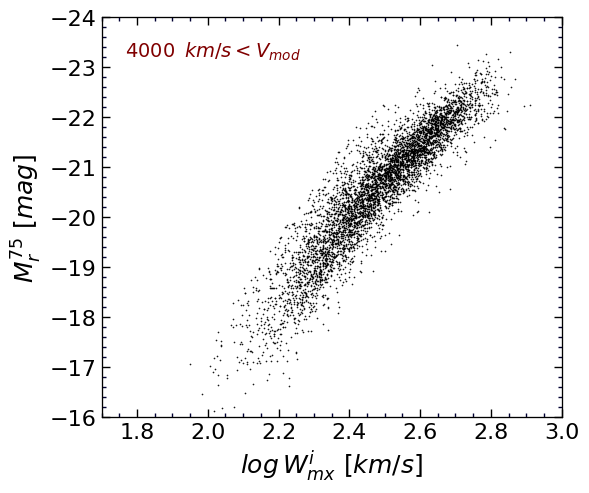

In [13]:
def bilinear2(x, m1, b1, m2, b2):
    y1 = m1 * x + b1
    y2 = m2 * x + b2
    y = np.asarray([y1[i] if x[i]<=M0 else y2[i] for i in range(len(x))])
    return y

dff = df[(df.Qs>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>4000)]

fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

X0 = dff.lgWmxi.values
X0e = dff.elgWi.values
Y0 = dff.Mr_75.values
ID = dff.index.values


def bilinear(x, m1, b1, m2, eps):
    x0 = -20+eps 
    b2 = b1 - x0*(m2-m1)
    y1 = m1 * x + b1
    y2 = m2 * x + b2
    y = np.asarray([y1[i] if x[i]<=x0 else y2[i] for i in range(len(x))])
    return y



fit, cov = curve_fit(bilinear, Y0, X0-2.5, sigma=np.sqrt(X0e**2+0.01**2))
M0 = -20+fit[3] 


fit, cov = curve_fit(bilinear2, Y0, X0-2.5, sigma=np.sqrt(X0e**2+0.01**2))
m1 = fit[0] ; dm1 = cov[0][0]
b1 = fit[1] ; db1 = cov[1][1]
m2 = fit[2] ; dm2 = cov[2][2]
b2 = fit[3] ; db2 = cov[3][3]

m1e = np.sqrt(dm1)
b1e = np.sqrt(db1)
mbe = cov[1,0]    
m10 = 1./m1
b10 = -b1/m1
dm10 = np.abs(m1e/m1**2)
db10 = np.sqrt((b10**2 )*(b1e**2/b1**2+m1e**2/m1**2-2*mbe/m1/b1))


m2e = np.sqrt(dm2)
b2e = np.sqrt(db2)
mbe = cov[2,3]    
m20 = 1./m2
b20 = -b2/m2
dm20 = np.abs(m2e/m2**2)
db20 = np.sqrt((b20**2 )*(b2e**2/b2**2+m2e**2/m2**2-2*mbe/m2/b2))

v = np.linspace(-24,M0,100)
u = m1*v + b1 + 2.5
# ax.plot(u, v, '-', color='black')
v = np.linspace(M0,-14,100)
u = m2*v + b2 + 2.5
# ax.plot(u, v, '-', color='purple')


ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$M^{75}_{r} \/\/ [mag]$', fontsize=18)
set_axes(ax, (1.7,3), (-16,-24))



Wh = (M0-b10)/m10+2.5
Wl = (M0-b20)/m20+2.5

W0 = 0.5*(Wh+Wl)

N = len(X0)
Mfid = np.zeros(N)
for i in range(N):
    
    if X0[i]<W0:
        Mf = m20*(X0[i]-2.5)+b20
    else:
        Mf = m10*(X0[i]-2.5)+b10
    
    Mfid[i] = Mf
    
delta = Y0-Mfid
keep, = np.where(np.abs(delta)<2.0*np.std(delta))

## scatter plot
ax.plot(X0[keep], Y0[keep], 'ko', alpha=0.9, ms=1.2, mfc='k', mec='none') 


Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.95*Xlm[0]+0.05*Xlm[1]
y0 = 0.1*Ylm[0]+0.90*Ylm[1]
ax.text(x0,y0, r"$4000\/\/\/km/s <V_{mod}$" % dm20, fontsize=14, color='maroon')

iter:  0
iter:  1
3.274 10.315363995868095


/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-26-08242295c225>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['delta'] = 0.
<ipython-input-26-08242295c225>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['delta'] = m0*(dff.lgWmxi-2.5)+b0 - dff.logMb
<ipython-input-26-08242295c225>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy 

Text(1.7650000000000001, 11.200000000000001, '$ZP_{75} = $10.315$\\pm$0.002')

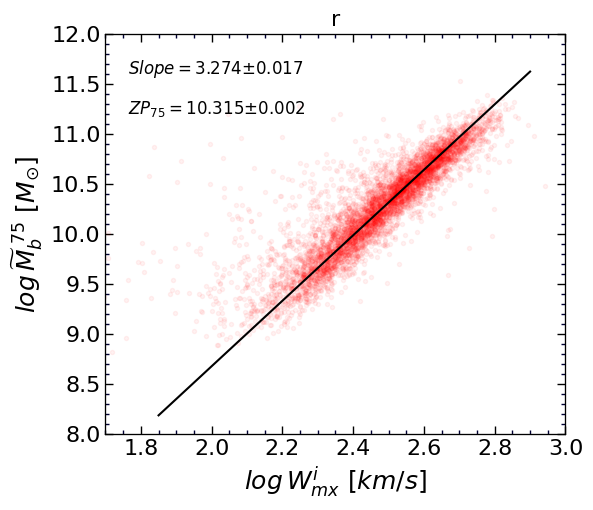

In [26]:
df['Mb'] = df.Ms_r + 1.33*(10**(np.log10(df.Mass_HI)+HI_corrector(mc, 0, df.V3k.values)))
df['logMb'] = np.log10(df.Mb.values)

calib['Mb'] = calib.Ms_r + 1.33*(10**(np.log10(calib.Mass_HI)+HI_corrector(mc, 0, calib.V3k.values)))
calib['logMb'] = np.log10(calib.Mb.values)

dff = df[(df.Qs>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>4000)]
std = 1.E10
dff['delta'] = 0.

for jj in range(2):
    
    dff = dff[np.abs(dff.delta)<3.5*std]

    logW = dff.lgWmxi.values
    logWe = dff.elgWi.values
    logMass = dff.logMb.values
    V3k = dff.V3k.values

    ln10 = np.log(10)
    dMs = 0.4*0.05*ln10
    dM21 = 2.356E5 * dff.eF21.values * (dff.D75.values**2)
    dMb = np.sqrt(dMs**2+(1.33**2)*dM21**2)
    Mb = dff.Ms_W1.values + 1.33*(10**(np.log10(dff.Mass_HI.values)))
    dlogMb = dMb/Mb/ln10


    fit, cov = curve_fit(linear, logMass, logW-2.5, sigma=np.sqrt(logWe**2+(0.01)**2))
    m, b = fit[0], fit[1]
    me = np.sqrt(cov[0,0])
    be = np.sqrt(cov[1,1])
    mbe = cov[1,0]    
    m0 = 1./m
    b0 = -b/m
    dm0 = np.abs(me/m**2)
    db0 = np.sqrt((b0**2 )*(be**2/b**2+me**2/m**2-2*mbe/m/b))
    
    
#     if jj>0:
#         mcfit = lts_linefit(logW-2.5, logMass, np.sqrt(logWe**2+(0.01)**2), 0.*dlogMb+0.01, clip=3.) 

    dff = df[(df.Qs>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>4000)]
    dff['delta'] = m0*(dff.lgWmxi-2.5)+b0 - dff.logMb
    std = dff['delta'].std()
    
    print("iter: ", jj)
    

m0 = 3.274
    
logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMb.values

fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

##################################################################
def linear_zp(x, zp):
    
    return x/m0+zp

X = calib.lgWmxi.values
Xe = calib.elgWi.values
Y = calib.logMb.values
MM = calib.Mi.values
So = calib.So.values

fit, cov = curve_fit(linear_zp, Y, X-2.5, sigma=np.sqrt(Xe**2+(0.01)**2))
zp_calib = -fit[0]*m0
zp_calib_e = np.sqrt(cov[0][0])*m0

Y = Y - zp_calib + b0

logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMb.values
ax.plot(logW, logMass, '.', color='red', alpha=0.05) 


# ind, = np.where((MM>-17)&(So==2))
# ax.plot(X[ind], Y[ind], '*', ms=10, color='blue', mfc='white') 
# ind, = np.where((MM<=-17)&(So==2))
# ax.plot(X[ind], Y[ind], '*', ms=10, color='blue', alpha=0.7, label='TRGB+CPLR') 


# ind, = np.where((MM>-17)&(So==0))
# ax.plot(X[ind], Y[ind], 'D', ms=5, color='springgreen', mfc='white') 
# ind, = np.where((MM<=-17)&(So==0))
# ax.plot(X[ind], Y[ind], 'D', ms=5, color='springgreen', alpha=0.7, label='CPLR') 


# ind, = np.where((MM>-17)&(So==1))
# ax.plot(X[ind], Y[ind], 'o', ms=5, color='k', mfc='white') 
# ind, = np.where((MM<=-17)&(So==1))
# ax.plot(X[ind], Y[ind], 'o', ms=5, color='k', label='TRGB') 

# ax.plot([0], [0], '.', color='red', label='Main Sample', mfc='white') 
#######################################################################



w = np.linspace(1.85,2.9,100)
ax.plot(w, m0*(w-2.5) + b0, 'k-')
print(m0,b0)    

    
    
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/ \widetilde{M}_b^{\/\/75} \/\/ [M_{\odot}]$', fontsize=18)
set_axes(ax, (1.7,3), (8,12))

ax.set_title("r", fontsize=16)

Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.95*Xlm[0]+0.05*Xlm[1]
y0 = 0.1*Ylm[0]+0.9*Ylm[1]
ax.text(x0,y0, r"$Slope = $"+"%.3f" % m0+'$\pm$'+"%.3f" % dm0, fontsize=12, color='k')
y0 = 0.2*Ylm[0]+0.8*Ylm[1]
ax.text(x0,y0, r"$ZP_{75} = $"+"%.3f" % b0+'$\pm$'+"%.3f" % db0, fontsize=12, color='k')



# x0 = 0.45*Xlm[0]+0.55*Xlm[1]
# y0 = 0.93*Ylm[0]+0.07*Ylm[1]
# ax.text(x0,y0, "%d"%len(Xe)+' Zeropoint Galaxies', fontsize=11, color='maroon')
# y0 = 0.83*Ylm[0]+0.17*Ylm[1]
# ax.text(x0,y0, r"$ZP_{calib} = $"+"%.3f" % zp_calib+'$\pm$'+"%.3f" % zp_calib_e, fontsize=11, color='maroon')

# ax.legend(bbox_to_anchor=(0.65, 0.50), loc=2)

In [15]:
# b0 = zp_calib

In [16]:
def getDMr(mag, Wlog, F21, m0, b0, D, gi, V3k):
    
    Mb = 10**(m0*(Wlog-2.5)+b0)
    
    M21 = 2.356E5 * F21 * (D**2)
    M21 = 10**(np.log10(M21) + HI_corrector(mc, 0, V3k))
    
    Mag = -2.5*(np.log10(Mb - 1.33*M21) - (alfa*gi+beta))
    
    DM = mag - Mag
    
    D = 10**((DM-25)/5)
    
    return D


def interpol(X, Y):
    
    X0 = X[~np.isnan(Y)]
    Y0 = Y[~np.isnan(Y)]
      
    N = len(X0)
    
    for i in range(N-1):
        
        if Y0[i]<0 and Y0[i+1]>0:
            break

    return -Y0[i]*(X0[i+1]-X0[i])/(Y0[i+1]-Y0[i])+X0[i]

In [17]:
dff = df[(df.Qs>0)&(df.elgWi>0)&(df.lgWmxi>0)]
mag = dff["r***"].values
Wlog = dff.lgWmxi.values
F21 = dff.F21.values
D75 = dff.D75.values
gi = dff.gi.values
V3k = dff.V3k.values
PGC = dff.index.values

N = len(dff)
M1_fid = np.zeros(N)
print(N)
pp=0

for j in range(N):
    mag_ = mag[j]

    D = np.arange(600)
    delta = D*0.

    for i in range(600):
        delta[i] =  D[i] - getDMr(mag[j], Wlog[j], F21[j], m0, b0, D[i], gi[j], V3k[j])


    D = D[~np.isnan(delta)]
    delta = delta[~np.isnan(delta)]

    try:
#         D_left = np.max(D[delta<0])
#         D_right = np.min(D[delta>0])
#         D_root = 0.5*(D_left+D_right)
        D_root = interpol(D, delta)
        DM_fid = 5*np.log10(D_root)+25
        M1_fid[j] = mag_ - DM_fid
    except:
        D_root = np.max(D[delta<0])
        DM_fid = 5*np.log10(D_root)+25
        M1_fid[j] = mag_ - DM_fid    
        print("flag (j, pgc): ", j, PGC[j])
        pp+=1
    if j%1000==0:
        print(j)
    if PGC[j]==1781:
        print(j, mag_, DM_fid, D_root)

print("Number of concerning distances:", pp)

7502
0


<ipython-input-16-72822a274e6c>:6: RuntimeWarning: divide by zero encountered in log10
  M21 = 10**(np.log10(M21) + HI_corrector(mc, 0, V3k))
<ipython-input-16-72822a274e6c>:8: RuntimeWarning: invalid value encountered in log10
  Mag = -2.5*(np.log10(Mb - 1.33*M21) - (alfa*gi+beta))


184 14.74 29.6115609373485 8.362038975540802
1000
2000
3000
4000
5000
6000
7000
Number of concerning distances: 0


<ipython-input-18-50b1007b60a0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['dDM'] = M1_fid - dff.Mr_75.values


Text(0.5, 1.0, 'BTFR: r-band')

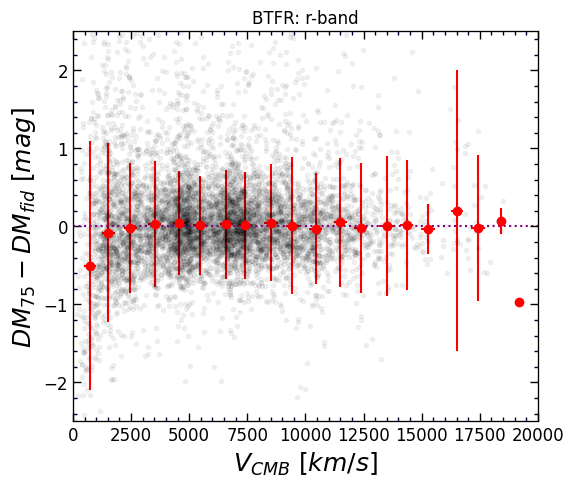

In [18]:
dff['dDM'] = M1_fid - dff.Mr_75.values

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.V3k.values
Y = dff.dDM.values
# logW = dff.lgWmxi.values

# X = X[logW>2.3]
# Y = Y[logW>2.3]


ax.plot(X, Y, 'k.', alpha=0.05)

for i in np.arange(0,20000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$V_{CMB} \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$DM_{75} - DM_{fid}\/\/[mag]$', fontsize=18)
# ax.set_ylabel(r'$log \/ (D_{75}/D_{fid})$', fontsize=18)

ax.plot([0,20000], [0,0], ':', color='purple')

set_axes(ax, (0,20000), (-2.5,2.5), fontsize=12)

ax.set_title("BTFR: r-band")

Text(0.5, 1.0, 'BTFR: r-band')

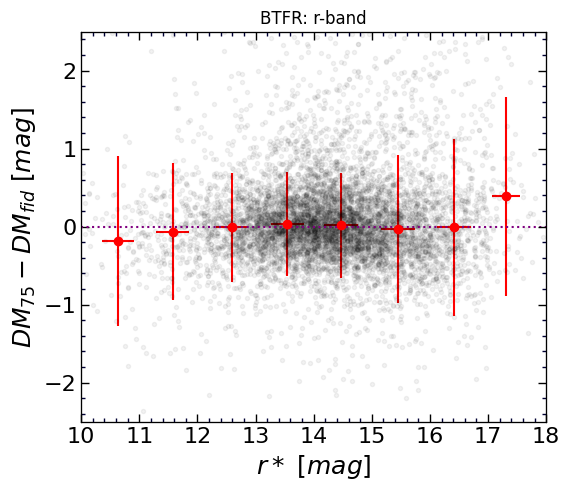

In [19]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff['r***'].values
Y = dff.dDM.values
V = dff.V3k.values


ax.plot(X, Y, 'k.', alpha=0.05)

for i in np.arange(10,18,1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1 and ~np.isnan(xi) and ~np.isnan(Y[ii]):
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.mean(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$r* \/\/[mag]$', fontsize=18) 
ax.set_ylabel(r'$DM_{75} - DM_{fid}\/\/[mag]$', fontsize=18)
# ax.set_ylabel(r'$log \/ (D_{75}/D_{fid})$', fontsize=18)


ax.plot([10,18], [0,0], ':', color='purple')

set_axes(ax, (10,18), (-2.5,2.5))

ax.set_title("BTFR: r-band")

Text(0.5, 1.0, 'BTFR: r-band')

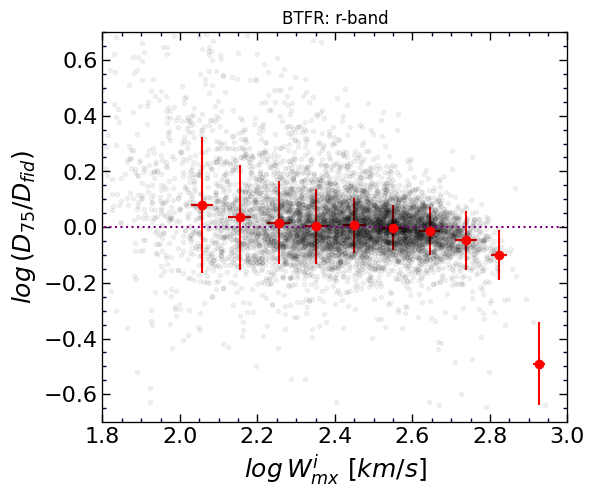

In [20]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.lgWmxi.values
Y = dff.dDM.values/5.
V = dff.Vmod.values


ax.plot(X, Y, 'k.', alpha=0.05)

for i in np.arange(2,3,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1 and ~np.isnan(xi) and ~np.isnan(Y[ii]):
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.mean(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18)
# ax.set_ylabel(r'$DM_{75} - DM_{fid}$', fontsize=18)
ax.set_ylabel(r'$log \/ (D_{75}/D_{fid})$', fontsize=18)


ax.plot([10,18], [0,0], ':', color='purple')
ax.plot([-10,10], [0,0], ':', color='purple')

set_axes(ax, (1.8,3), (-0.7,0.7))

ax.set_title("BTFR: r-band")

In [21]:
dff['DMr_fid'] = dff["r***"] - M1_fid

dff[['V3k', 'Vmod', 'DM_75', 'DMr_fid', 'F21', 'eF21', 'lgWmxi', 'elgWi', 'Qs', 'r***', 'logMs_r']].to_csv("BTFR_r_distances.csv")

<ipython-input-21-1eb0b38e6d37>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['DMr_fid'] = dff["r***"] - M1_fid
